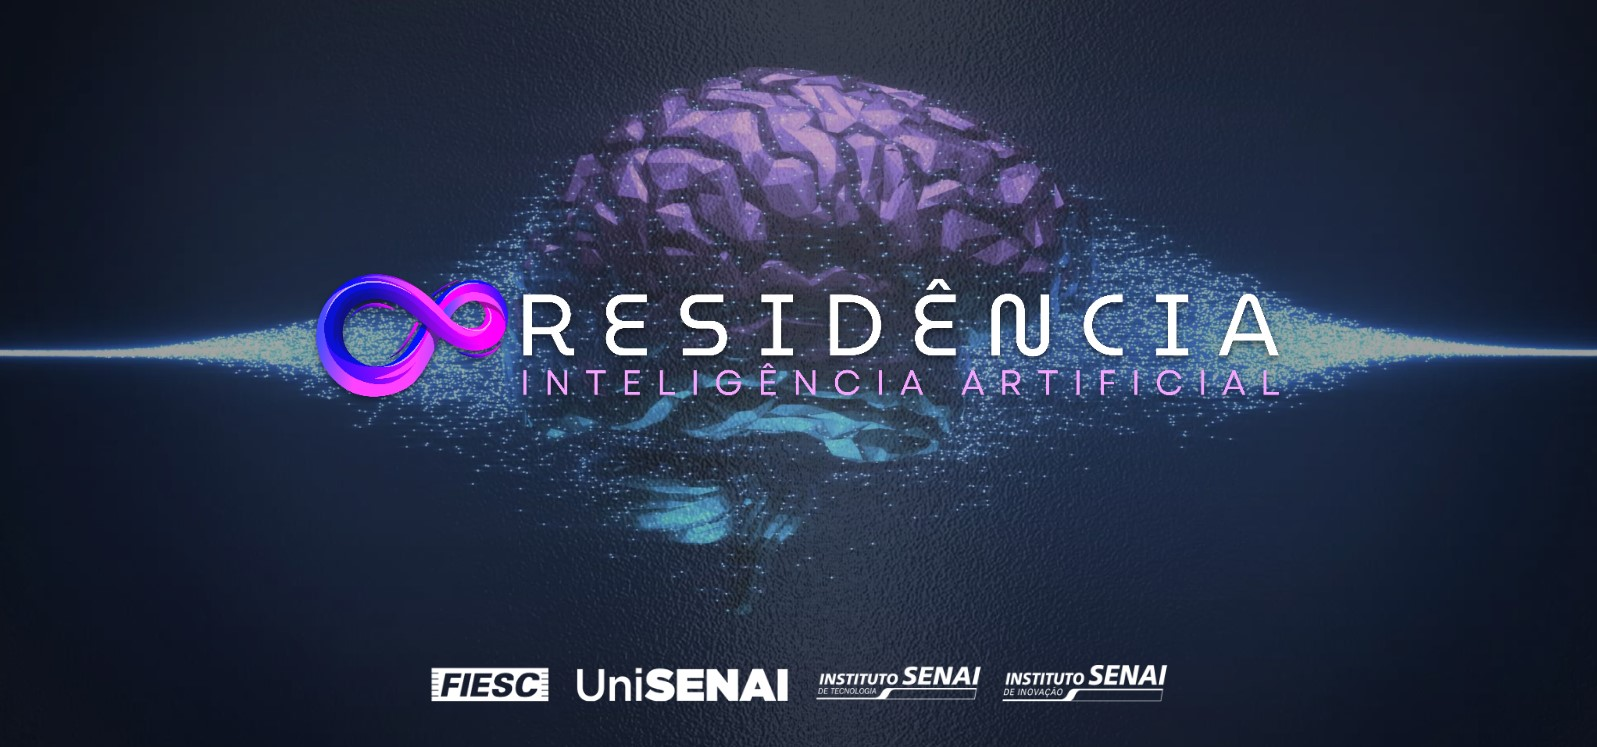


## Projeto Final Bootcamp Ciência de Dados e Inteligência Artificial
## **Candidato**: Rafael de Olioveira Lima
## **Data**: 01/09/2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline

KeyboardInterrupt: 

In [ ]:
#Inicialmente vamos carregar o dataset
df = pd.read_csv('bootcamp_train.csv')

In [ ]:
# Visualizar os dados para 
df.head()

Nesta estapa já foi possível verificar a existência de missing values no dataset disponibilizados. Portanto, será necessário tratar os dados.

In [ ]:
# Analisamos nosso dataset para verificar o volume de dados que serão tratados.
df.shape

In [ ]:
#Verificamos a existência de missingvalues no dataset
df.info()

In [ ]:
df.isnull().sum()

Como já havia sido observado anteriomente, verificamos que há missing values no dataset. 
Contudo, não vamos retirar as linhas com missingvalues, iremos substituir pela mediana de cada variável.

In [ ]:
df['temperatura_ar'] = df['temperatura_ar'].fillna(df['temperatura_ar'].median())
df['temperatura_processo'] = df['temperatura_processo'].fillna(df['temperatura_processo'].median())
df['velocidade_rotacional'] = df['velocidade_rotacional'].fillna(df['velocidade_rotacional'].median())
df['torque'] = df['torque'].fillna(df['torque'].median())
df['desgaste_da_ferramenta'] = df['desgaste_da_ferramenta'].fillna(df['desgaste_da_ferramenta'].median())

In [ ]:
df.info()

Verificamos que após o tratamento dos danos não há mais missing values.

In [ ]:
df.shape

In [ ]:
df.nunique()

Precebemos que ainda há problemas no dataset, pois para algumas colunas deveríamos ter apenas dois valores distintos. Por exemplo, em falha_maquina, pois deveria ser sim ou não.

In [ ]:
# Vamos padronizar as colunas com variáveis categóricas com True ou False
columns_to_standardize = [
    'falha_maquina',
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)'
]


for col in columns_to_standardize:
    df[col] = df[col].astype(str).str.lower().replace({
        'não': False,
        'nao': False,
        'n': False,
        'false': False,
        '0': False
    })

 
    df[col] = df[col].replace({'true': True, 't': True, 'sim': True, 's': True, '1': True, 'não': False, 'nao': False, 'n': False, 'false': False, '0': False})


for col in columns_to_standardize:
    df[col] = df[col].apply(lambda x: False if not x or pd.isna(x) or str(x).lower() in ['não', 'nao', 'n', 'false', '0'] else True)

Susbstituímos as negações por False. Para não perder informação eliminando as linhas que contém zero, substuímos zero pela moda e 1 por True. (Utilizamos variáveis Boleanas)
Desta forma obtivemos apenas dois valores distintos para as variáveis categóricas, True ou False.
Esta padronização é necessária para que os dados possam ser utilizados para uma análise multilabel.

In [ ]:
df.nunique()

Após as substutuições percebemos que agora há apenas dois valores distintos para as variáveis que deveriam ter apenas dois valores distintos.

In [ ]:
df.shape

Agora vamos fazer a análise do boxplot para verificar a existência de outliers.

In [ ]:
def plot_boxplots_category(df, column, category_col):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=category_col, y=column, hue=category_col, palette='tab10')
    plt.title(f'Boxplot de {column} por {category_col}')
    plt.xlabel(category_col)
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_boxplots_category(df,'temperatura_ar','tipo')
plot_boxplots_category(df,'temperatura_processo','tipo')
plot_boxplots_category(df,'umidade_relativa','tipo')
plot_boxplots_category(df,'velocidade_rotacional','tipo')
plot_boxplots_category(df,'torque','tipo')
plot_boxplots_category(df,'desgaste_da_ferramenta','tipo')


Analisando os bloxplot podemos perceber facilmente a existência de outliers.
Mas não vamos retirar todos os outliers, pois os valores atipicos podem estar associados às falhas que as máquinas podem apresentar. 

Bucando contornar este problema, será realizada uma análise de cada uma das variáveis numérias para analisar os valores que são fisicamente impossíveis. Os valores improváveis de ocorrer serão retirados.

In [ ]:
df['temperatura_ar'].value_counts(normalize=True).sort_index() *100

In [ ]:
df = df[df['temperatura_ar'] != -36.0]

In [ ]:
df['temperatura_processo'].value_counts(normalize=True).sort_index() *100

In [ ]:
df = df[df['temperatura_processo'] != -38.0]

In [ ]:
df['umidade_relativa'].value_counts(normalize=True).sort_index() *100

In [ ]:
df['velocidade_rotacional'].value_counts(normalize=True).sort_index() *100

In [ ]:
df = df[df['velocidade_rotacional'] != -161.0]

In [ ]:
df['torque'].value_counts(normalize=True).sort_index() *100

In [ ]:
df['desgaste_da_ferramenta'].value_counts(normalize=True).sort_index() *100

In [ ]:
df = df[df['desgaste_da_ferramenta'] != -202.0]

In [ ]:
def plot_correlation_matrix(df):
    corr_df = df[df.select_dtypes(include=['float']).columns]  # Apenas atributos contínuos
    plt.figure(figsize=(10, 8))
    correlation_matrix = corr_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='seismic', fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlação')
    plt.show()

In [ ]:
plot_correlation_matrix(df)

Com base na matriz de correlação, podemos oberservar forte correlação positiva da temperatura de processo com a temperatura do ar.
Também pode-se observar a correlação negativa entre velocidade rotacional e torque.

In [ ]:
df.to_csv('new_dataset',index=False)

**Vamos iniciar o pré-prcessamento**

In [ ]:
#vamos carregar o novo conjunto de dados após a análise exploratória
df_2 = pd.read_csv('new_dataset')

In [ ]:
df_2.shape

Primeiramente, vamos fazer uma cópia do dataset.
Inicaremos com uma análise binária.

In [ ]:
df_2.head()

In [ ]:
#Para a análise binária, vamos utilizar como variável alvo: falha_maquina
X = df_2.drop(columns=['falha_maquina','id','id_produto','FDF (Falha Desgaste Ferramenta)','FDC (Falha Dissipacao Calor)','FP (Falha Potencia)','FTE (Falha Tensao Excessiva)','FA (Falha Aleatoria)','tipo']).copy()
y = df_2['falha_maquina'].copy()

Dividindo o conunto de dados do dataset entre treinamento e teste. Selecionamos 80% dos dados para treinamento e 20% para teste.

In [ ]:
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

Precisamos garantir que a variável alvo esteja em forma numérica para que possa ser interpretado pelo algoritimo.

In [ ]:
y_train

In [ ]:
X_train

In [ ]:
numerical = X_train.select_dtypes(include='number').columns.tolist()

In [ ]:
numerical

In [ ]:
leb = LabelEncoder()

In [ ]:
y_train = leb.fit_transform(y_train)
y_test = leb.fit_transform(y_test)

In [ ]:
y_train

In [ ]:
y_test

In [ ]:
leb.classes_

In [ ]:
X_train_min_max = X_train.copy()

In [ ]:
#Normalização dos dados do dataset
scaler = MinMaxScaler()

In [ ]:
X_train_min_max[numerical] = scaler.fit_transform(X_train_min_max[numerical])

In [ ]:
X_train_min_max.head()

In [ ]:
X_train_min_max['temperatura_ar'].min()

In [ ]:
X_train_min_max['temperatura_ar'].max()

In [ ]:
#Balanceamento dos dados
smote = SMOTE(random_state=42)

In [ ]:
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_res_min_max, y_train_res = smote.fit_resample(X_train_min_max, y_train)

Foram realizados vários teste utilizando os dados sem pré-processamento e com pré-processamento

**O treinamento será realizado usando os algoritimos KNN e  Randon Forest**

KNN

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train,y_train)

In [ ]:
y_pred_knn = knn.predict(X_test)

In [ ]:
target_names = [str(c) for c in leb.classes_]
print(classification_report(y_test, y_pred_knn, target_names=target_names))

SVM

In [ ]:
svm = SVC(probability=True)

In [ ]:
svm.fit(X_train, y_train)

In [ ]:
y_pred_svm = svm.predict(X_test)

In [ ]:
target_names = [str(c) for c in leb.classes_]
print(classification_report(y_test, y_pred_svm, target_names=target_names))

Random Forest

Para os cálculos com o algoritimo Randon Forest os hiperparâmetros foram otimizados.

In [ ]:
#Random Forest
rf = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

In [ ]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__criterion': ['gini', 'entropy']
}

In [ ]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
y_pred_RF = grid_search.predict(X_test)

In [ ]:
target_names = [str(c) for c in leb.classes_]
print(classification_report(y_test, y_pred_RF, target_names=target_names))

In [ ]:
print("Melhores parâmetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

**VAMOS APLICAR O MODELO AOS DADOS DISPONIBILIZADOS**

Para analisar o dataset disponibilizado foi utilizado algoritimo Random Forest com os hiperparâmetros otimizados

In [ ]:
df_test_bin = pd.read_csv('bootcamp_test.csv')

# Mantém apenas as colunas de treino
X_test_bin = df_test_bin[X.columns]

# Previsões

y_pred_bin = best_model.predict(X_test_bin)
y_proba = best_model.predict_proba(X_test_bin)

# Monta DataFrame de resultados
pred_bin_df = pd.DataFrame({
    "id": df_test_bin['id'] if "id" in df_test_bin.columns else range(len(df_test_bin)),
    "pred_binaria": y_pred_bin,
    "pred_label": pd.Series(y_pred_bin).map({0: "Sem falha", 1: "Falha"}),
    "proba_sem_falha": y_proba[:, 0],
    "proba_falha": y_proba[:, 1]
})

print(pred_bin_df.head())

# Salva em CSV
pred_bin_df.to_csv("Resultado.csv", index=False)


**Vamos utilizar o algoritimo Random Forest para realizar uma análise multilabel**

In [ ]:
df_2['tipo_de_falha'] = 'Sem Falha'
df_2.loc[df_2['FDF (Falha Desgaste Ferramenta)'] == True, 'tipo_de_falha'] = 'Falha Desgaste Ferramenta'
df_2.loc[df_2['FDC (Falha Dissipacao Calor)'] == True, 'tipo_de_falha'] = 'Falha Dissipacao Calor'
df_2.loc[df_2['FP (Falha Potencia)'] == True, 'tipo_de_falha'] = 'Falha Potencia'
df_2.loc[df_2['FTE (Falha Tensao Excessiva)'] == True, 'tipo_de_falha'] = 'Falha Tensao Excessiva'
df_2.loc[df_2['FA (Falha Aleatoria)'] == True, 'tipo_de_falha'] = 'Falha Aleatoria'

In [ ]:
X = df_2.drop(columns=['falha_maquina','id','id_produto','FDF (Falha Desgaste Ferramenta)','FDC (Falha Dissipacao Calor)','FP (Falha Potencia)','FTE (Falha Tensao Excessiva)','FA (Falha Aleatoria)','tipo','tipo_de_falha']).copy()
y = df_2['tipo_de_falha'].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
numerical = X_train.select_dtypes(include='number').columns.tolist()

In [ ]:
leb = LabelEncoder()

In [ ]:
y_train = leb.fit_transform(y_train)
y_test = leb.fit_transform(y_test)

In [ ]:
leb.classes_

In [ ]:
X_train_min_max = X_train.copy()

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_min_max[numerical] = scaler.fit_transform(X_train_min_max[numerical])

In [ ]:
X_train_min_max.head()

In [ ]:
X_train_min_max['temperatura_ar'].min()

In [ ]:
X_train_min_max['temperatura_ar'].max()

In [ ]:
smote = SMOTE(random_state=42)

In [ ]:
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_res_min_max, y_train_res = smote.fit_resample(X_train_min_max, y_train)

In [ ]:
rf = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

In [ ]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__criterion': ['gini', 'entropy']
}

In [ ]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search.fit(X_train_res, y_train_res)

In [ ]:
y_pred_RF_2 = grid_search.predict(X_test)

In [ ]:
target_names = [str(c) for c in leb.classes_]
print(classification_report(y_test, y_pred_RF_2, target_names=target_names))

**OBSERVAÇÔES**

O modelo de classificação desenvolvido está claramente viésado para a classe majoritária, que corresponde aos casos sem falha. Isso significa que, embora o modelo seja eficiente em identificar corretamente a ausência de falhas, ele possui desempenho limitado na detecção de falhas reais, correspondendo à classe minoritária do conjunto de dados.

Esse viés indica que o modelo atual não está equilibrado, refletindo o desbalanceamento dos dados de treinamento. Para melhorar a capacidade de identificar corretamente a classe minoritária (presseça de falhas), seria recomendada uma análise mais aprofundada, incluindo:

Outras técnicas de balanceamento de dados;

Ajuste de pesos das classes durante o treinamento;

Avaliação de outros algoritmos de classificação, que possam lidar melhor com classes desbalanceadas;

Em resumo, embora o modelo seja promissor para identificar a ausência de falhas, sua capacidade de detecção de falhas ainda é limitada, e ajustes adicionais são necessários para torná-lo adequado para aplicações práticas em manutenção preditiva.